In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping
import pandas as pd
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


# number of data
N=4000
# size of each sample
L=2
# box size
B=100

!mkdir DATA

A subdirectory or file DATA already exists.


**Non-linear functions**

In [2]:
def f(x,c=1):
    r=0
    if c==1:
        if x[0]>-25 and x[1]>-35 and x[0]+x[1] < 30:
            r=1
        if x[0]+x[1] > 50:
            r=1
    if c==2:
        if (np.sign(x[0]-0.2*x[1]))*np.cos(np.linalg.norm(x)/(1.5*np.pi))>0:
            r=1
    return r


def filename(s,TYPE=1):
    return "./DATA/"+s+"-for-DNN-"+str(TYPE)+".dat"

def boundaries():  
    x1=-25
    y1=-35
    c="#AAAAFF"
    a=0.5
    lw=5
    ax.plot((50,-20),(-20,50),c=c,alpha=a,lw=lw)
    ax.plot((50,0),(0,50),c=c,alpha=a,lw=lw)
    ax.plot((x1,50),(y1,y1),c=c,alpha=a,lw=lw)
    ax.plot((x1,x1),(y1,50),c=c,alpha=a,lw=lw)

**Genererate Data**

<function matplotlib.pyplot.show(close=None, block=None)>

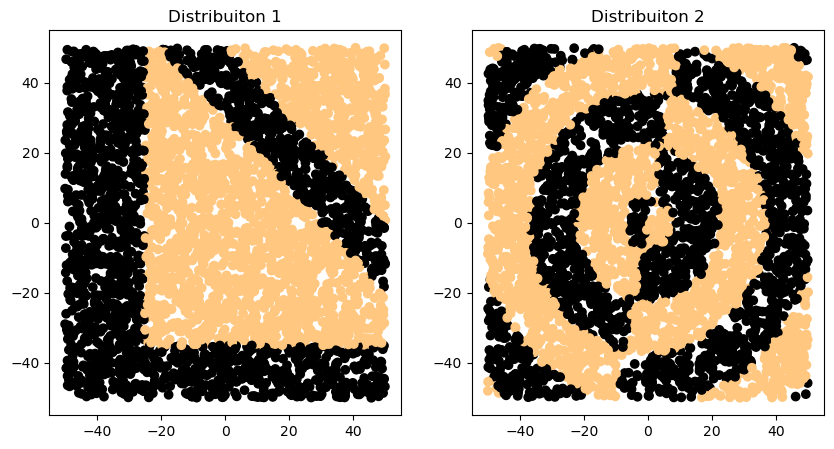

In [3]:
TYPE=1

# random seed for reproducibility
np.random.seed(12345)

def generate_data(TYPE):
    x,y = (np.random.random((N,2))-0.5)*B, np.zeros(N)
    for i in range(N):
        # label data according to a nonlinear function "f"
        y[i] = f(x[i],TYPE)
    return x, y

x1, y1 = generate_data(1)
x2, y2 = generate_data(2)

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axis[0].scatter(x1[:,0],x1[:,1],c=y1,cmap=cm.copper)
axis[0].set_title("Distribuiton 1")
axis[1].scatter(x2[:,0],x2[:,1],c=y2,cmap=cm.copper)
axis[1].set_title("Distribuiton 2")

plt.show

***Distribution 1***

In [4]:
#Number of total samples
N=len(x1)
#Training set
perc_train=0.8
N_train = int(perc_train * N)

#Split training and validation set 
(x1_train, y1_train) = (x1[0:N_train],y1[0:N_train])
(x1_valid, y1_valid) = (x1[N_train:],y1[N_train:])
print("Train:",len(x1_train),"\t Validation:",len(x1_valid))

#Rescale data
def Rescale(x):
    #return (x-x.mean())/np.sqrt(x.var())
    return x/50

x1_train = Rescale(x1_train)
x1_valid = Rescale(x1_valid)


Train: 3200 	 Validation: 800


**Define DNN**

In [5]:
# fix random seed for reproducibility
seed = 12345
tf.random.set_seed(seed)

def base_model():
    model = Sequential()
    model.add(Dense(2,input_shape=(2,),activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    #Compile model
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

def create_model(optimizer="adam"):
    #create model layer by layer
    model = Sequential()
    model.add(Dense(2,input_shape=(2,),activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [13]:
model = KerasClassifier(model=base_model)
base_model = model.fit(x1_train, y1_train,
               epochs = 500, batch_size = 50,
               validation_data=(x1_valid,y1_valid),
               verbose=0)

[[-1.   -1.  ]
 [-0.96 -1.  ]
 [-0.92 -1.  ]
 ...
 [ 0.92  1.  ]
 [ 0.96  1.  ]
 [ 1.    1.  ]]


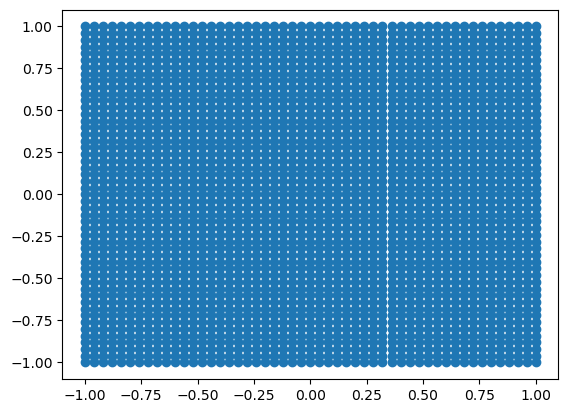

In [23]:
#Test accuracy of data
dX = 2
X1 = np.arange(-50,50+dX, dX)

LG = len(X1)
grid = np.zeros((LG*LG,2))
#print(grid)
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
grid_r=grid/50
print(grid_r)
plt.scatter(grid_r[:,0], grid_r[:,1])





<function matplotlib.pyplot.show(close=None, block=None)>

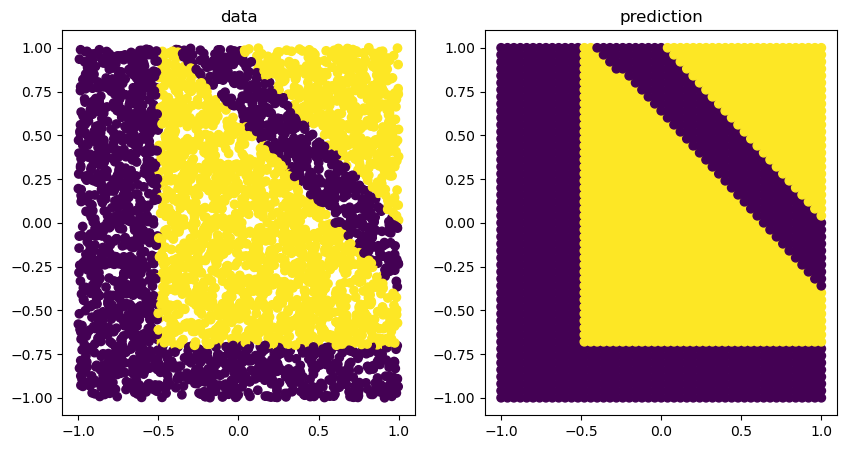

In [8]:

fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Total data
axis[0].scatter(x1[:,0]/50,x1[:,1]/50,c=y1)
axis[0].set_title("data")

#Generated data

axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred)
axis[1].set_title("prediction")

plt.show

**Tune Batch Size, number of epochs and algorithm**

In [14]:
def create_model(optimizer='adam'):
    #create model layer by layer
    model = Sequential()
    model.add(Dense(2,input_shape=(2,),activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


#create model 
model = KerasClassifier(model=create_model, verbose = 0)

#define the grid search parameters
batch_size = [ 40, 60 ]
epochs = [10,50,100]
optimizer = [ "Adam", "Adamax", "Nadam" ]
param_grid = dict(batch_size=batch_size, epochs= epochs,optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result=grid.fit(x1,y1)

In [15]:
#best parameters for getting high accuracy
best_parameters = grid_result.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

The best combination of hyperparameters is: {'batch_size': 60, 'epochs': 50, 'optimizer': 'Nadam'}
The accuracy obtained for those previous values is: 0.8610017946765551


In [16]:
result_6 = pd.DataFrame(grid_result.cv_results_)
result = result_6[["param_batch_size","param_epochs", "param_optimizer","mean_test_score" ]]
result

,param_batch_size,param_epochs,param_optimizer,mean_test_score
0,40,10,Adam,0.747017
1,40,10,Adamax,0.711995
2,40,10,Nadam,0.750004
3,40,50,Adam,0.814991
4,40,50,Adamax,0.800494
5,40,50,Nadam,0.751982
6,40,100,Adam,0.798233
7,40,100,Adamax,0.843266
8,40,100,Nadam,0.857246
9,60,10,Adam,0.692509


**Tune activation function and optimization algorithm**

In [ ]:
def create_model(optimizer='adam', activation="relu"):
    #create model layer by layer
    model = Sequential()
    model.add(Dense(2,input_shape=(2,),activation=activation))
    model.add(Dense(20,activation=activation))
    model.add(Dense(20,activation=activation))
    model.add(Dense(20,activation=activation))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


#create model 
model = KerasClassifier(model=create_model,epochs=100, batch_size=40, verbose = 0)

#define the grid search parameters
optimizer = ["SGD", "Adagrad",  "Adam",  "Nadam" ]
activation = ["softmax",  "relu", "tanh", "sigmoid", "linear"]
param_grid = dict(model__activation=activation ,optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result=grid.fit(x1,y1)



In [ ]:
#best parameters for getting high accuracy
best_parameters = grid_result.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

The best combination of hyperparameters is: {'model__activation': 'relu', 'optimizer': 'Adagrad'}
The accuracy obtained for those previous values is: 0.8752512340978797


In [ ]:
def create_model_dropout(dropout_rate, weight_constraint):
    model = Sequential()
    model.add(Dense(2, input_shape=(2,), activation = 'relu', kernel_constraint=MaxNorm(weight_constraint)))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = "sigmoid"))
    # compile model
    model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics=["accuracy"])
    return model

model_dropout = KerasClassifier(model= create_model_dropout, epochs = 100, batch_size=40, verbose = 0)
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint = weight_constraint)
grid_6 = GridSearchCV(estimator=model_dropout, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result_6=grid_6.fit(x1,y1)


In [ ]:
#best parameters for getting high accuracy
best_parameters = grid_result_6.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result_6.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

The best combination of hyperparameters is: {'model__dropout_rate': 0.0, 'model__weight_constraint': 2.0}
The accuracy obtained for those previous values is: 0.8700010459886336


In [ ]:
result_6 = pd.DataFrame(grid_result.cv_results_)
result_6
result = result_6[["param_model__activation", "param_optimizer","mean_test_score" ]]
result

,param_model__activation,param_optimizer,mean_test_score
0,softmax,SGD,0.682996
1,softmax,Adagrad,0.767752
2,softmax,Adam,0.724741
3,softmax,Nadam,0.740265
4,relu,SGD,0.807755
5,relu,Adagrad,0.875251
6,relu,Adam,0.832999
7,relu,Nadam,0.870753
8,tanh,SGD,0.703764
9,tanh,Adagrad,0.697985


In [17]:
def final_model():
    #create model layer by layer
    model = Sequential()
    model.add(Dense(2, input_shape=(2,), activation = 'relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.0))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
    return model

model = KerasClassifier(model=final_model)
final_model = model.fit(x1_train, y1_train,
               epochs = 500, batch_size = 40,
               validation_data=(x1_valid,y1_valid),
               verbose=1)



Epoch 1/500
80/80 [==============================] - 2s 16ms/step - loss: 0.6943 - accuracy: 0.4106 - val_loss: 0.6932 - val_accuracy: 0.4162
Epoch 2/500
80/80 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.4847 - val_loss: 0.6910 - val_accuracy: 0.5500
Epoch 3/500
80/80 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.5422 - val_loss: 0.6894 - val_accuracy: 0.5713
Epoch 4/500
80/80 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5641 - val_loss: 0.6879 - val_accuracy: 0.5800
Epoch 5/500
80/80 [==============================] - 0s 2ms/step - loss: 0.6875 - accuracy: 0.5838 - val_loss: 0.6865 - val_accuracy: 0.5975
Epoch 6/500
80/80 [==============================] - 0s 2ms/step - loss: 0.6861 - accuracy: 0.5947 - val_loss: 0.6850 - val_accuracy: 0.6050
Epoch 7/500
80/80 [==============================] - 0s 2ms/step - loss: 0.6847 - accuracy: 0.5997 - val_loss: 0.6836 - val_accuracy: 0.6075
Epoch 8/500


82/82 [==============================] - 0s 930us/step


<function matplotlib.pyplot.show(close=None, block=None)>

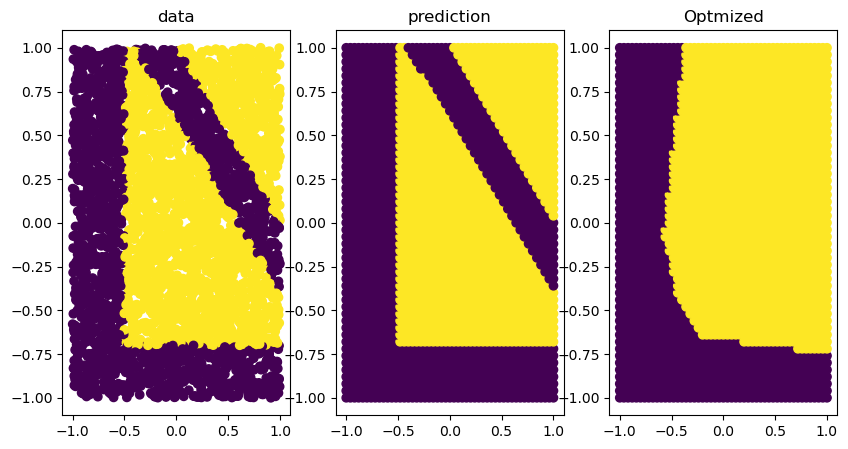

In [18]:

pred_optimized = final_model.predict(grid_r)

fig, axis = plt.subplots(1, 3, figsize=(10,5))

#Total data
axis[0].scatter(x1[:,0]/50,x1[:,1]/50,c=y1)
axis[0].set_title("data")

#Generated data without optimization

axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred)
axis[1].set_title("prediction")

#Generated data with optimization

axis[2].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized)
axis[2].set_title("Optmized")
plt.show

In [9]:
 
def new_model(optimizer="adam", activation="relu"):
    model = Sequential()
    model.add(Dense(2,input_shape=(2,),activation=activation))
    model.add(Dense(20,activation=activation))
    model.add(Dense(20,activation=activation))
    model.add(Dense(20,activation=activation))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    #Compile model
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    return model

#create model 
model = KerasClassifier(model=new_model, verbose = 1)

#define the grid search parameters
batch_size = [ 40, 60,80, 100 ]
epochs = [20,50,100]
optimizer = ["SGD", "Adagrad",  "Adam",  "Nadam" ]
activation = ["softmax",  "relu", "tanh", "sigmoid", "linear"]
param_grid = dict(batch_size=batch_size, epochs= epochs,optimizer=optimizer, model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result=grid.fit(x1,y1, callbacks=[early_stopping])


Epoch 1/100
67/67 [==============================] - 3s 2ms/step - loss: 0.8741 - accuracy: 0.5550
Epoch 2/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6692 - accuracy: 0.6140
Epoch 3/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6515 - accuracy: 0.6237
Epoch 4/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6392 - accuracy: 0.6267
Epoch 5/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6325 - accuracy: 0.6390
Epoch 6/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6294 - accuracy: 0.6345
Epoch 7/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6280 - accuracy: 0.6330
Epoch 8/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6258 - accuracy: 0.6415
Epoch 9/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6260 - accuracy: 0.6417
Epoch 10/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6254 - accuracy: 0.6380
Epoch 11/

In [11]:
#best parameters for getting high accuracy
best_parameters = grid_result.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

The best combination of hyperparameters is: {'batch_size': 60, 'epochs': 100, 'model__activation': 'relu', 'optimizer': 'Adam'}
The accuracy obtained for those previous values is: 0.8650016702076568


In [ ]:
if CASE==1:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400

In [29]:
 
def new_model():
    model = Sequential()
    model.add(Dense(2,input_shape=(2,),activation="relu"))
    model.add(Dense(20,activation="relu"))
    model.add(Dense(20,activation="relu"))
    model.add(Dense(20,activation="relu"))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    #Compile model
    model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
    return model

model = KerasClassifier(model=new_model)
final_model = model.fit(x1_train, y1_train,
               epochs = 500, batch_size = 60,
               validation_data=(x1_valid,y1_valid),
               verbose=1)

Epoch 1/500
54/54 [==============================] - 1s 6ms/step - loss: 0.6760 - accuracy: 0.6031 - val_loss: 0.6557 - val_accuracy: 0.6125
Epoch 2/500
54/54 [==============================] - 0s 2ms/step - loss: 0.6419 - accuracy: 0.6403 - val_loss: 0.6277 - val_accuracy: 0.6263
Epoch 3/500
54/54 [==============================] - 0s 2ms/step - loss: 0.6186 - accuracy: 0.6478 - val_loss: 0.6151 - val_accuracy: 0.6350
Epoch 4/500
54/54 [==============================] - 0s 2ms/step - loss: 0.6055 - accuracy: 0.6538 - val_loss: 0.6094 - val_accuracy: 0.6413
Epoch 5/500
54/54 [==============================] - 0s 2ms/step - loss: 0.5967 - accuracy: 0.6609 - val_loss: 0.6056 - val_accuracy: 0.6475
Epoch 6/500
54/54 [==============================] - 0s 2ms/step - loss: 0.5919 - accuracy: 0.6659 - val_loss: 0.6017 - val_accuracy: 0.6450
Epoch 7/500
54/54 [==============================] - 0s 2ms/step - loss: 0.5868 - accuracy: 0.6722 - val_loss: 0.5979 - val_accuracy: 0.6513
Epoch 8/500
5

82/82 [==============================] - 0s 713us/step


<function matplotlib.pyplot.show(close=None, block=None)>

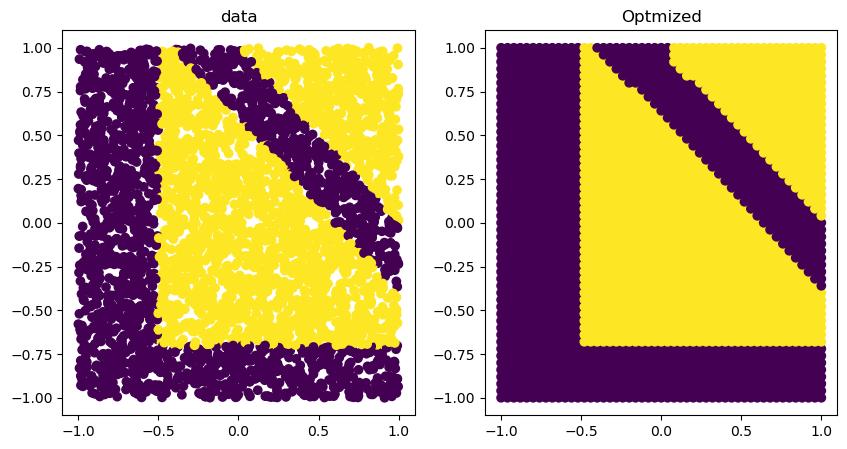

In [30]:

pred_optimized = final_model.predict(grid_r)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Total data
axis[0].scatter(x1[:,0]/50,x1[:,1]/50,c=y1)
axis[0].set_title("data")

#Generated data with optimization

axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized)
axis[1].set_title("Optmized")
plt.show

**Distribution 2**

Train: 3200 	 Validation: 800


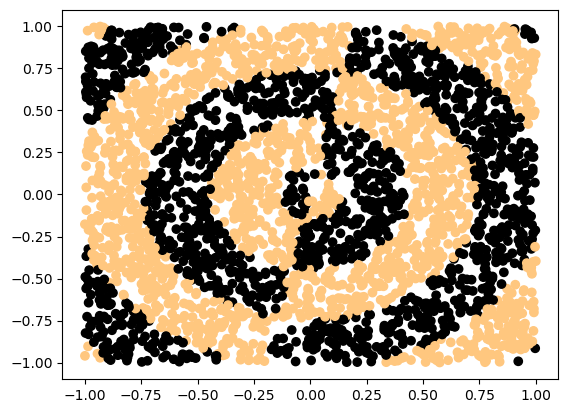

In [34]:
#Number of total samples
N=len(x2)
#Training set
perc_train=0.8
N_train = int(perc_train * N)

#Split training and validation set 
(x2_train, y2_train) = (x2[0:N_train],y2[0:N_train])
(x2_valid, y2_valid) = (x2[N_train:],y2[N_train:])
print("Train:",len(x2_train),"\t Validation:",len(x2_valid))

#Rescale data
def Rescale(x):
    #return (x-x.mean())/np.sqrt(x.var())
    return x/50

x2_train = Rescale(x2_train)
x2_valid = Rescale(x2_valid)
plt.scatter(x2_train[:,0],x2_train[:,1],c=y2_train,cmap=cm.copper)


In [49]:
 
def new_model():
    model = Sequential()
    model.add(Dense(2,input_shape=(2,),activation="relu"))
    model.add(Dense(20,activation="relu"))
    model.add(Dense(20,activation="relu"))
    model.add(Dense(20,activation="relu"))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    #Compile model
    model.compile(loss='binary_crossentropy',
              optimizer='Nadam',
              metrics=['accuracy'])
    return model

model = KerasClassifier(model=new_model)
final_model = model.fit(x2_train, y2_train,
               epochs = 500, batch_size = 10,
               validation_data=(x2_valid,y2_valid),
               verbose=1)

Epoch 1/500
320/320 [==============================] - 3s 2ms/step - loss: 0.6937 - accuracy: 0.5063 - val_loss: 0.6911 - val_accuracy: 0.5350
Epoch 2/500
320/320 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4913 - val_loss: 0.6923 - val_accuracy: 0.5150
Epoch 3/500
320/320 [==============================] - 0s 1ms/step - loss: 0.6939 - accuracy: 0.4947 - val_loss: 0.6929 - val_accuracy: 0.4938
Epoch 4/500
320/320 [==============================] - 0s 1ms/step - loss: 0.6937 - accuracy: 0.4975 - val_loss: 0.6922 - val_accuracy: 0.5350
Epoch 5/500
320/320 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5072 - val_loss: 0.6909 - val_accuracy: 0.5350
Epoch 6/500
320/320 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.5022 - val_loss: 0.6925 - val_accuracy: 0.5150
Epoch 7/500
320/320 [==============================] - 1s 2ms/step - loss: 0.6930 - accuracy: 0.5056 - val_loss: 0.6923 - val_accuracy: 0.5063

In [47]:
 
def new_model():
    model = Sequential()
    model.add(Dense(2,input_shape=(2,),activation="relu"))
    model.add(Dense(20,activation="relu"))
    model.add(Dense(20,activation="relu"))
    model.add(Dense(20,activation="relu"))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    #Compile model
    model.compile(loss='binary_crossentropy',
              optimizer="Nadam",
              metrics=['accuracy'])
    return model

#create model 
batch_size = [ 10,40, 60,80,100 ]
epochs = [100,200,300,400,500]
model = KerasClassifier(model=new_model, epochs = 500, batch_size=60, verbose = 1)
param_grid = dict(batch_size=batch_size, epochs= epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result=grid.fit(x2,y2)



Epoch 1/500
400/400 [==============================] - 2s 1ms/step - loss: 0.8891 - accuracy: 0.5483
Epoch 2/500
400/400 [==============================] - 1s 1ms/step - loss: 0.6889 - accuracy: 0.5408
Epoch 3/500
400/400 [==============================] - 1s 1ms/step - loss: 0.6938 - accuracy: 0.5362
Epoch 4/500
400/400 [==============================] - 1s 1ms/step - loss: 0.6891 - accuracy: 0.5403
Epoch 5/500
400/400 [==============================] - 1s 1ms/step - loss: 0.6863 - accuracy: 0.5490
Epoch 6/500
400/400 [==============================] - 1s 1ms/step - loss: 0.6853 - accuracy: 0.5508
Epoch 7/500
400/400 [==============================] - 1s 1ms/step - loss: 0.6865 - accuracy: 0.5487
Epoch 8/500
400/400 [==============================] - 1s 1ms/step - loss: 0.6865 - accuracy: 0.5502
Epoch 9/500
400/400 [==============================] - 1s 1ms/step - loss: 0.6869 - accuracy: 0.5487
Epoch 10/500
400/400 [==============================] - 1s 1ms/step - loss: 0.6842 - accura

In [48]:
#best parameters for getting high accuracy
best_parameters = grid_result.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

The best combination of hyperparameters is: {'batch_size': 10, 'epochs': 500}
The accuracy obtained for those previous values is: 0.7172514642903605


82/82 [==============================] - 0s 1ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

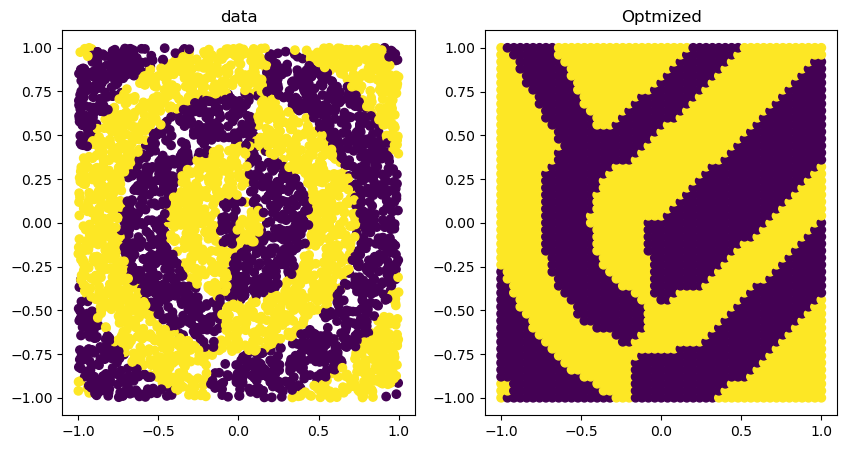

In [50]:

pred_optimized = final_model.predict(grid_r)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Total data
axis[0].scatter(x2[:,0]/50,x2[:,1]/50,c=y2)
axis[0].set_title("data")

#Generated data with optimization

axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized)
axis[1].set_title("Optmized")
plt.show